# 微调与引导

在本笔记本中，我们将介绍两种用于调整已有扩散模型（diffusion models）的方法：

* **微调（fine-tuning）**：在新数据上重新训练现有模型，以改变其输出类型  
* **引导（guidance）**：在推断阶段对现有模型的生成过程进行引导，以获得额外的控制  

## 你将学到什么

完成本笔记本后，你将掌握以下技能：

- 编写采样循环，并使用新的调度器更快地生成样本  
- 在新数据上微调现有扩散模型，包括：  
  - 使用梯度累积（gradient accumulation）解决小批量训练带来的问题  
  - 在训练过程中利用 [Weights and Biases](https://wandb.ai/site) 记录样本，以便监控进度（示例脚本提供）  
  - 保存训练得到的 pipeline 并上传至 Hugging Face Hub  
- 通过附加损失函数来引导采样过程，为现有模型增加控制能力，包括：  
  - 使用简单的基于颜色的损失探索不同的引导方法  
  - 利用 CLIP 结合文本提示词（text prompt）来引导生成  
  - 使用 Gradio 和 🤗 Spaces 共享自定义采样循环 


In [1]:
import numpy as np
import torch
import torch.nn.functional as F
import torchvision
from datasets import load_dataset
from diffusers import DDIMScheduler, DDPMPipeline
from matplotlib import pyplot as plt
from PIL import Image
from torchvision import transforms
from tqdm.auto import tqdm

d:\Users\yin-pu\miniconda3\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = (
    "mps"
    if torch.backends.mps.is_available()
    else "cuda"
    if torch.cuda.is_available()
    else "cpu"
)

## 加载预训练 Pipeline

首先，让我们加载一个现有的 pipeline，看看可以对它做些什么：

In [3]:
# 对于 Windows 用户：
# 设置 HF_ENDPOINT 环境变量为 Hugging Face 镜像源（用于国内加速），
# 然后使用 huggingface-cli 下载模型到本地指定目录。
!set HF_ENDPOINT=https://hf-mirror.com&&huggingface-cli download google/ddpm-celebahq-256 --local-dir ./google/ddpm-celebahq-256 --repo-type model

# 对于 Linux/macOS 用户，请使用以下命令（注意使用 export 而不是 set）：
# !export HF_ENDPOINT=https://hf-mirror.com&&huggingface-cli download google/ddpm-celebahq-256 --local-dir ./google/ddpm-celebahq-256 --repo-type model

D:\projects\diffusion-models-class-zh\unit2\google\ddpm-celebahq-256



Fetching 10 files: 100%|██████████| 10/10 [00:00<00:00, 631.81it/s]


In [4]:
image_pipe = DDPMPipeline.from_pretrained("./google/ddpm-celebahq-256")
image_pipe.to(device)

Loading pipeline components...:   0%|          | 0/2 [00:00<?, ?it/s]An error occurred while trying to fetch ./google/ddpm-celebahq-256: Error no file named diffusion_pytorch_model.safetensors found in directory ./google/ddpm-celebahq-256.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.
Loading pipeline components...: 100%|██████████| 2/2 [00:00<00:00, 35.28it/s]


DDPMPipeline {
  "_class_name": "DDPMPipeline",
  "_diffusers_version": "0.34.0",
  "_name_or_path": "./google/ddpm-celebahq-256",
  "scheduler": [
    "diffusers",
    "DDPMScheduler"
  ],
  "unet": [
    "diffusers",
    "UNet2DModel"
  ]
}

生成图像就像将管道的 [`__call__`](https://github.com/huggingface/diffusers/blob/main/src/diffusers/pipelines/ddpm/pipeline_ddpm.py#L42) 方法当作函数调用一样简单：


  0%|          | 0/1000 [00:00<?, ?it/s]d:\Users\yin-pu\miniconda3\Lib\site-packages\diffusers\models\attention_processor.py:3317: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:455.)
  hidden_states = F.scaled_dot_product_attention(
100%|██████████| 1000/1000 [00:45<00:00, 21.96it/s]


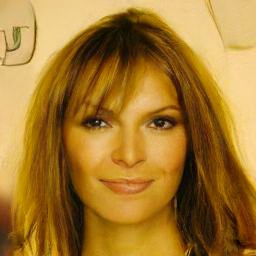

In [5]:
images = image_pipe().images
images[0]

很巧妙，但太慢了！所以，在进入今天的主要内容之前，让我们先来看看实际的采样循环，并探讨如何使用更先进的采样器来加速它：


## 使用 DDIM 的更快采样

在每一步中，模型都会接收一个带噪声的输入，并被要求预测噪声（从而估计完全去噪后图像的样貌）。起初，这些预测并不十分准确，因此我们将该过程分解为多个步骤。然而，实践证明，使用超过 1000 步是没有必要的，近期大量研究致力于探索如何在尽可能少的步骤中获得高质量的样本。  


在 🤗 Diffusers 库中，这些 **采样方法由调度器scheduler负责**，它必须通过 `step()` 函数执行每一次更新。  

要生成图像，我们从随机噪声 $x$ 开始。然后，对于调度器噪声时间表中的每一个时间步，我们将带噪输入 $x$ 提供给模型，并将模型的预测结果传递给 `step()` 函数。该函数返回一个带有 `prev_sample` 属性的输出——之所以称为 “prev” 是因为我们在时间上从高噪声向低噪声“倒退”（与正向扩散过程相反）。  

让我们来看看实际操作！首先，我们加载一个调度器scheduler，这里使用基于 [Denoising Diffusion Implicit Models](https://arxiv.org/abs/2010.02502) 论文的 DDIMScheduler，它能在远少于原始 DDPM 实现的步骤下生成不错的样本：  


In [6]:
# 新建调度器并设置推理步数
scheduler = DDIMScheduler.from_pretrained("./google/ddpm-celebahq-256")
scheduler.set_timesteps(num_inference_steps=40)

你可以看到该模型总共执行了 40 个步骤，每一步相当于原始 1000 步时间表中的 25 步：

In [7]:
scheduler.timesteps

tensor([975, 950, 925, 900, 875, 850, 825, 800, 775, 750, 725, 700, 675, 650,
        625, 600, 575, 550, 525, 500, 475, 450, 425, 400, 375, 350, 325, 300,
        275, 250, 225, 200, 175, 150, 125, 100,  75,  50,  25,   0])

让我们创建 4 个随机图像并运行采样循环，在过程中查看当前的 $x$ 以及预测的预测去噪结果：


0it [00:00, ?it/s]

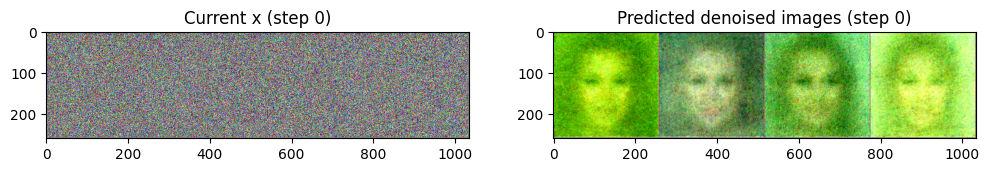

10it [00:01,  8.53it/s]

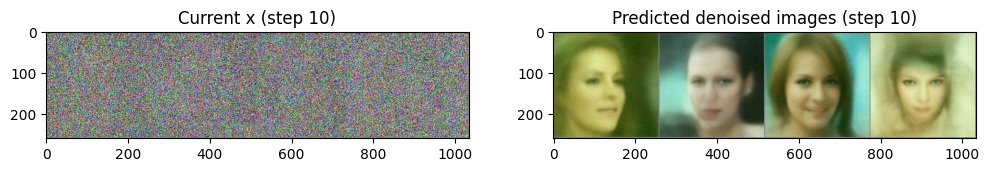

20it [00:02,  8.35it/s]

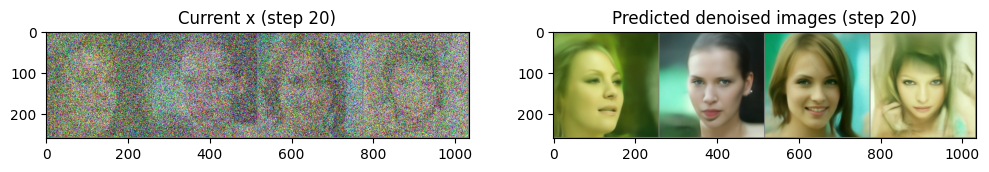

30it [00:04,  8.18it/s]

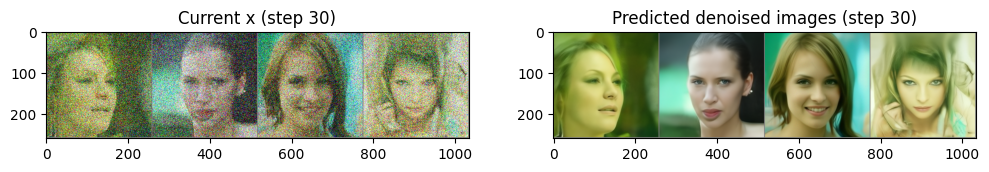

39it [00:05,  8.34it/s]

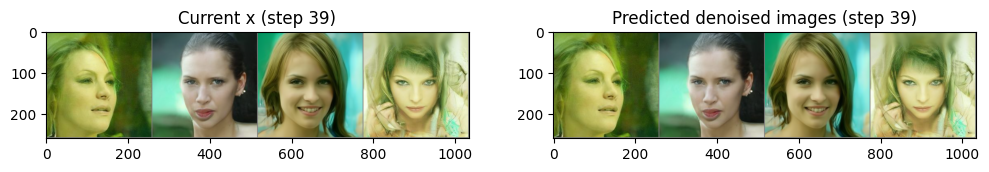

40it [00:05,  7.12it/s]


In [8]:
# 随机起始点
x = torch.randn(4, 3, 256, 256).to(device)  # 批量为 4，每张图 3 通道，尺寸 256×256 像素

# 逐步进行采样
for i, t in tqdm(enumerate(scheduler.timesteps)):

    # 准备模型输入
    model_input = scheduler.scale_model_input(x, t)

    # 预测噪声
    with torch.no_grad():
        noise_pred = image_pipe.unet(model_input, t)["sample"]

    # 使用调度器计算更新后的样本
    scheduler_output = scheduler.step(noise_pred, t, x)

    # 更新 x
    x = scheduler_output.prev_sample

    # 每隔 10 步或最后一步可视化当前样本与预测去噪结果
    if i % 10 == 0 or i == len(scheduler.timesteps) - 1:
        fig, axs = plt.subplots(1, 2, figsize=(12, 5))

        grid = torchvision.utils.make_grid(x, nrow=4).permute(1, 2, 0)
        axs[0].imshow(grid.cpu().clip(-1, 1) * 0.5 + 0.5)
        axs[0].set_title(f"Current x (step {i})")

        pred_x0 = scheduler_output.pred_original_sample  # 并非所有调度器都提供该属性
        grid = torchvision.utils.make_grid(pred_x0, nrow=4).permute(1, 2, 0)
        axs[1].imshow(grid.cpu().clip(-1, 1) * 0.5 + 0.5)
        axs[1].set_title(f"Predicted denoised images (step {i})")
        plt.show()


如你所见，初始预测效果并不理想，但随着流程的进行，预测输出会变得越来越精细。

您还可以将此新调度器替换原始pipeline中附带的调度器，并按如下方式进行采样：  


100%|██████████| 40/40 [00:01<00:00, 22.11it/s]


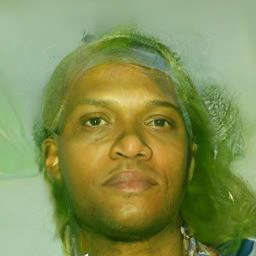

In [9]:
image_pipe.scheduler = scheduler
images = image_pipe(num_inference_steps=40).images
images[0]

好了——我们现在可以在合理的时间内获取样本了！这样在继续本笔记本剩余内容时，效率会更高 :)  

## 微调（Fine-Tuning）

现在轮到好玩的部分了！在已有的预训练管线基础上，我们如何利用新的训练数据重新训练模型，从而生成对应的图像？

其实，这一流程与从零开始训练模型（参见 [Unit 1](../unit1)）几乎完全相同，只不过我们从现有模型出发。接下来，让我们实践一遍，并在过程中讨论几项额外的注意事项。


首先，数据集：你可以尝试使用 [这个复古人脸数据集](https://huggingface.co/datasets/Norod78/Vintage-Faces-FFHQAligned) 或者 [这些动漫人脸数据集](https://huggingface.co/datasets/huggan/anime-faces)，它们更接近期初脸部模型的原始训练数据。但为了好玩，我们还是沿用 Unit 1 中从零开始训练时使用的那个小型蝴蝶数据集。运行下面的代码即可下载蝴蝶数据集，并创建一个能够为我们随机采样图像batch的 DataLoader：



Fetching 4 files: 100%|██████████| 4/4 [00:00<00:00, 520.66it/s]
Repo card metadata block was not found. Setting CardData to empty.


D:\projects\diffusion-models-class-zh\unit2\huggan\smithsonian_butterflies_subset
Previewing batch:


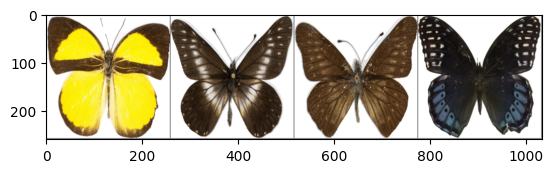

In [10]:
# 对于 Windows 用户：
# 设置 HF_ENDPOINT 环境变量为 Hugging Face 镜像源（用于国内加速），
# 然后使用 huggingface-cli 下载数据集到本地指定目录。
!set HF_ENDPOINT=https://hf-mirror.com&&huggingface-cli download huggan/smithsonian_butterflies_subset --local-dir ./huggan/smithsonian_butterflies_subset --repo-type dataset

# 对于 Linux/macOS 用户，请使用以下命令（注意使用 export 而不是 set）：
# !export HF_ENDPOINT=https://hf-mirror.com&&huggingface-cli download huggan/smithsonian_butterflies_subset --local-dir ./huggan/smithsonian_butterflies_subset --repo-type dataset

dataset_name = "./huggan/smithsonian_butterflies_subset"  # @param
dataset = load_dataset(dataset_name, split="train")
image_size = 256  # @param
batch_size = 4  # @param
preprocess = transforms.Compose(
    [
        transforms.Resize((image_size, image_size)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5]),
    ]
)


def transform(examples):
    images = [preprocess(image.convert("RGB")) for image in examples["image"]]
    return {"images": images}


dataset.set_transform(transform)

train_dataloader = torch.utils.data.DataLoader(
    dataset, batch_size=batch_size, shuffle=True
)

print("Previewing batch:")
batch = next(iter(train_dataloader))
grid = torchvision.utils.make_grid(batch["images"], nrow=4)
plt.imshow(grid.permute(1, 2, 0).cpu().clip(-1, 1) * 0.5 + 0.5)

**注意事项 1：** 此处的批量大小仅为 4，这是因为我们在 256 px 的大尺寸图像上训练一个相当庞大的模型——如果把批量大小调得更大，GPU 显存就会不足。你可以通过减小图像尺寸来提升训练速度并允许使用更大的批量大小，但请记住，这些模型最初的设计与训练目标分辨率就是 256 px。


## 训练

接下来是训练。我们通过将优化目标设为 `image_pipe.unet.parameters()` 来更新预训练模型的权重。其他部分几乎与单元 1 中的示例训练循环完全相同。在 Colab 上运行大约需要 10 分钟，所以正好可以去泡杯咖啡或茶，稍作休息。


  0%|          | 0/250 [00:00<?, ?it/s]d:\Users\yin-pu\miniconda3\Lib\site-packages\diffusers\configuration_utils.py:141: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDIMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDIMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)
100%|██████████| 250/250 [01:26<00:00,  2.88it/s]


Epoch 0 average loss: 0.013234982942114584


100%|██████████| 250/250 [01:26<00:00,  2.89it/s]

Epoch 1 average loss: 0.012340625108743552


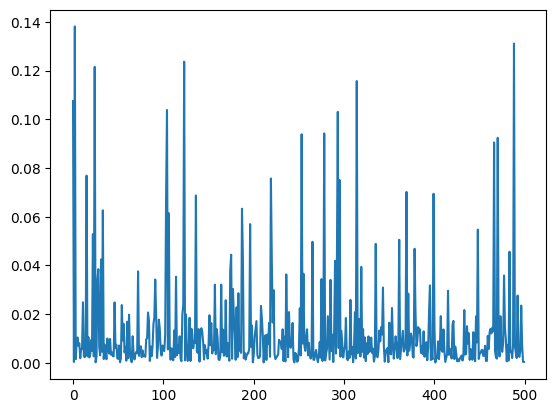

In [11]:
num_epochs = 2  # 训练轮数
lr = 1e-5       # 学习率
grad_accumulation_steps = 2  # 梯度累积步数

optimizer = torch.optim.AdamW(image_pipe.unet.parameters(), lr=lr)

losses = []

for epoch in range(num_epochs):
    for step, batch in tqdm(enumerate(train_dataloader), total=len(train_dataloader)):
        clean_images = batch["images"].to(device)
        
        # 为图像生成随机噪声
        noise = torch.randn(clean_images.shape).to(clean_images.device)
        bs = clean_images.shape[0]

        # 为每张图像随机采样一个时间步
        timesteps = torch.randint(
            0,
            image_pipe.scheduler.num_train_timesteps,
            (bs,),
            device=clean_images.device,
        ).long()

        # 按照每个时间步的噪声幅度向干净图像中加入噪声
        # （即前向扩散过程）
        noisy_images = image_pipe.scheduler.add_noise(clean_images, noise, timesteps)

        # 使用模型预测噪声
        noise_pred = image_pipe.unet(noisy_images, timesteps, return_dict=False)[0]

        # 将预测的噪声与真实噪声进行比较
        # 注意：我们要预测的是噪声 ε，而不是 (noisy_images - clean_images) 或 clean_images 本身
        loss = F.mse_loss(noise_pred, noise)

        # 保存损失，便于后续绘图
        losses.append(loss.item())

        # 根据损失更新模型参数
        loss.backward()

        # 梯度累积
        if (step + 1) % grad_accumulation_steps == 0:
            optimizer.step()
            optimizer.zero_grad()

    print(
        f"Epoch {epoch} average loss: {sum(losses[-len(train_dataloader):]) / len(train_dataloader)}"
    )

# 绘制损失曲线
plt.plot(losses)


**注意事项 2：** 由于每一步我们只在batch_size=4上、且使用随机噪声强度进行训练，损失信号非常嘈杂，这对训练并不理想。一个解决办法是使用极低的学习率，以限制每一步参数更新的幅度。如果能在 **不** 让显存需求飙升的前提下，获得与使用较大批量大小相同的效果，那就更好了……

这时就轮到 [梯度累积](https://kozodoi.me/python/deep%20learning/pytorch/tutorial/2021/02/19/gradient-accumulation.html#:~:text=Simply%20speaking%2C%20gradient%20accumulation%20means,might%20find%20this%20tutorial%20useful.) 登场了。如果我们在调用 `optimizer.step()` 和 `optimizer.zero_grad()` 之前多次执行 `loss.backward()`，PyTorch 会将梯度 **累加（求和）**——相当于把多个小批次的信号合并在一起，得到一次更好的梯度估计，然后再用它来更新参数。这样，总的参数更新次数就会减少，就像使用更大批量大小时的情况一样。许多框架都可以自动帮你完成这件事（例如 [🤗 Accelerate 让这变得很简单](https://huggingface.co/docs/accelerate/usage_guides/gradient_accumulation)），但自己从零实现一遍也很有价值，因为这是在受限 GPU 内存条件下训练模型的实用技巧！正如上面代码中（`# 梯度累积` 注释之后的部分）所示，实现它所需的代码其实非常少。

练习：尝试在 Unit 1 的训练循环中加入梯度累积。效果如何？思考一下是否需要根据梯度累积步数调整学习率——学习率应该保持和之前一样吗？


40it [00:09,  4.40it/s]


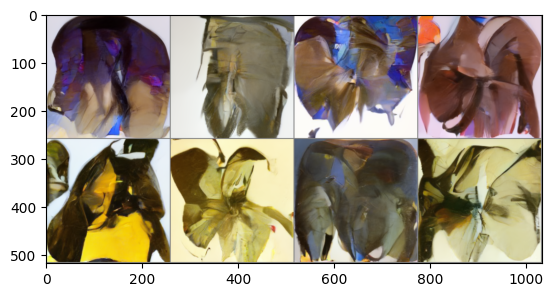

In [ ]:
x = torch.randn(8, 3, 256, 256).to(device) 
for i, t in tqdm(enumerate(scheduler.timesteps)):
    model_input = scheduler.scale_model_input(x, t)
    with torch.no_grad():
        noise_pred = image_pipe.unet(model_input, t)["sample"]
    x = scheduler.step(noise_pred, t, x).prev_sample
grid = torchvision.utils.make_grid(x, nrow=4)
plt.imshow(grid.permute(1, 2, 0).cpu().clip(-1, 1) * 0.5 + 0.5);

**注意事项 3：**  微调可能非常不可预测！如果我们训练更长时间，可能会看到一些完美的蝴蝶。但中间阶段本身就极具趣味性，特别是如果你对艺术方面更感兴趣的话！可以尝试非常短或非常长的训练周期，并调整学习率，看看这些变化如何影响最终模型的输出类型。

### 保存微调后的pipeline

现在我们已在扩散模型中微调了 U-Net，让我们通过运行以下命令将其保存到本地文件夹：

In [18]:
image_pipe.save_pretrained("my-finetuned-model")

## 引导（Guidance）

如果我们希望对生成的样本进行一定程度的控制，该怎么办？例如，假设我们想让生成的图像偏向某种特定的颜色，该如何实现呢？这时就要用到 **Guidance** —— 一种在采样过程中加入额外控制的技术。


第一步是创建我们的 **条件函数**：也就是我们希望最小化的某种度量（损失）。下面这段示例代码适用于颜色任务——它将图像像素与目标颜色（默认是一种浅青色）逐像素比较，并返回平均误差。

In [19]:
def color_loss(images, target_color=(0.1, 0.9, 0.5)):
    """
    给定一个目标颜色 (R, G, B)，返回图像中像素平均偏离该颜色的损失。
    默认目标颜色为浅青色: (0.1, 0.9, 0.5)
    """
    # 将目标颜色映射到 (-1, 1) 区间
    target = torch.tensor(target_color).to(images.device) * 2 - 1
    # 调整形状为 (batch, channel, height, width) 以匹配 images
    target = target[None, :, None, None]
    # 计算图像像素与目标颜色之间的平均绝对误差
    error = torch.abs(images - target).mean()
    return error

接下来，我们将对采样循环进行修改，使其在每一步执行以下操作：

- 创建一个新的 `x` 并将 `requires_grad` 设为 `True`  
- 计算去噪后的版本（`x0`）  
- 将预测得到的 `x0` 传入我们的损失函数  
- 计算该损失函数对 `x` 的 **梯度**  
- 在调度器（scheduler）step之前，用这一条件梯度修正 `x`，以期按照我们的引导函数（guidance function）将 `x` 推向更低损失的方向  

这里有两种可探索的变体：  

1. **先**通过 UNet 获取噪声预测，再对 `x` 设置 `requires_grad`。这种方式更节省显存（无需回溯梯度至扩散模型），但得到的梯度精度较低。  
2. **先**对 `x` 设置 `requires_grad`，再将其输入 UNet 并计算预测的 `x0`，以获得更准确的梯度。  

1it [00:00,  3.09it/s]

0 loss: 32.21052169799805


11it [00:02,  4.24it/s]

10 loss: 15.44047737121582


21it [00:05,  4.24it/s]

20 loss: 15.485294342041016


31it [00:07,  4.25it/s]

30 loss: 15.711200714111328


40it [00:09,  4.24it/s]


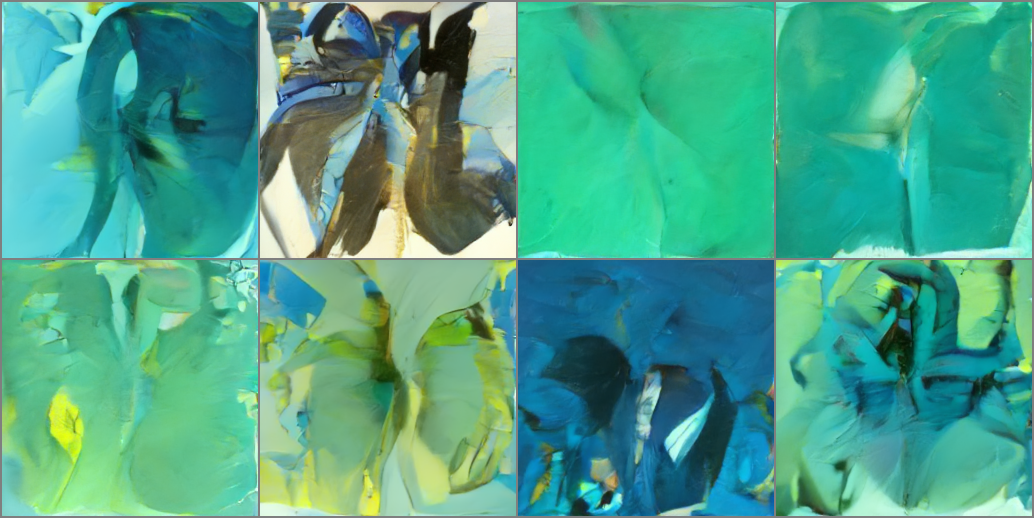

In [21]:
# 变体 1

# guidance_loss_scale 决定引导效果的强度
guidance_loss_scale = 40  # 可尝试修改为 5 或 100

x = torch.randn(8, 3, 256, 256).to(device)

for i, t in tqdm(enumerate(scheduler.timesteps)):

    # 准备用于模型的输入
    model_input = scheduler.scale_model_input(x, t)

    # 预测噪声残差
    with torch.no_grad():
        noise_pred = image_pipe.unet(model_input, t)["sample"]

    # 将 x.requires_grad 设为 True，以便计算梯度
    x = x.detach().requires_grad_()

    # 获取预测的 x0
    x0 = scheduler.step(noise_pred, t, x).pred_original_sample

    # 计算损失
    loss = color_loss(x0) * guidance_loss_scale
    if i % 10 == 0:
        print(i, "loss:", loss.item())

    # 计算梯度（取负号以进行梯度上升）
    cond_grad = -torch.autograd.grad(loss, x)[0]

    # 根据梯度更新 x
    x = x.detach() + cond_grad

    # 使用调度器前进一步
    x = scheduler.step(noise_pred, t, x).prev_sample

# 查看输出
grid = torchvision.utils.make_grid(x, nrow=4)
im = grid.permute(1, 2, 0).cpu().clip(-1, 1) * 0.5 + 0.5
Image.fromarray(np.array(im * 255).astype(np.uint8))


尽管我们只生成四张图像而不是八张，但第二种方案却需要几乎两倍的 GPU 显存。试着找出其中的差别，并思考为什么这种方法会更“准确”：


1it [00:00,  1.73it/s]

0 loss: 30.875242233276367


11it [00:02,  4.19it/s]

10 loss: 11.698451042175293


21it [00:05,  4.23it/s]

20 loss: 11.344587326049805


31it [00:07,  4.21it/s]

30 loss: 11.523704528808594


40it [00:09,  4.12it/s]


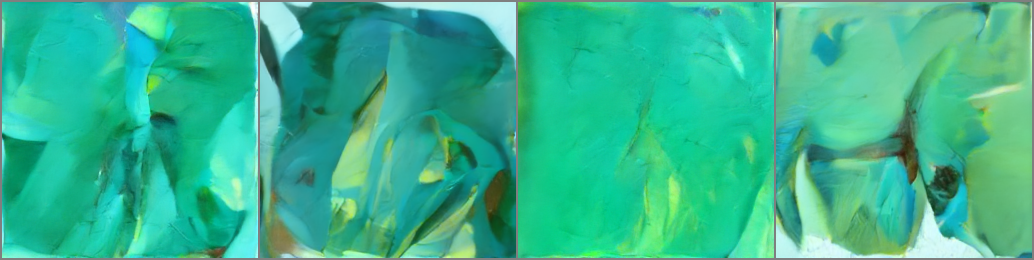

In [22]:
# 方案 2：在模型前向传播之前就设置 x.requires_grad

guidance_loss_scale = 40  # 引导损失缩放系数，可根据需要调整
x = torch.randn(4, 3, 256, 256).to(device)  # 随机初始化噪声图像

for i, t in tqdm(enumerate(scheduler.timesteps)):

    # 在模型前向传播之前设置 requires_grad，以便后续计算梯度
    x = x.detach().requires_grad_()
    model_input = scheduler.scale_model_input(x, t)  # 根据时间步缩放输入

    # 预测噪声残差（此时需要梯度）
    noise_pred = image_pipe.unet(model_input, t)["sample"]

    # 通过调度器得到预测的 x0（去噪后的图像）
    x0 = scheduler.step(noise_pred, t, x).pred_original_sample

    # 计算损失：这里使用颜色损失并乘以引导系数
    loss = color_loss(x0) * guidance_loss_scale
    if i % 10 == 0:
        print(i, "loss:", loss.item())  # 每 10 步打印一次损失

    # 计算梯度（取负号，进行梯度上升以强化目标特性）
    cond_grad = -torch.autograd.grad(loss, x)[0]

    # 根据梯度更新 x
    x = x.detach() + cond_grad

    # 使用调度器前进一步，生成下一个时间步的图像
    x = scheduler.step(noise_pred, t, x).prev_sample

# 将最终结果拼接成网格并可视化
grid = torchvision.utils.make_grid(x, nrow=4)
im = grid.permute(1, 2, 0).cpu().clip(-1, 1) * 0.5 + 0.5
Image.fromarray(np.array(im * 255).astype(np.uint8))


## CLIP 引导（CLIP Guidance）

color guidance仅仅将生成结果偏向某种颜色能带来一些控制力，但如果我们只想输入文字描述即可生成想要的图像呢？

[CLIP](https://openai.com/blog/clip/) 是 OpenAI 提出的一个模型，能够比较图像与文本描述之间的相似度。这非常强大，因为它让我们可以量化一幅图像与提示文本的匹配程度。而且由于整个过程是可微的，我们可以把这种匹配度当作损失函数，用来引导扩散模型！

下面给出简要思路（不深入细节）：

- **将文本提示** 转换为一个 512 维的 CLIP 文本嵌入向量  
- **在扩散模型的每一步** 中：  
  - 生成若干个当前去噪图像的变体（多生成几个版本可以得到更干净的损失信号）  
  - 对每个变体，使用 CLIP 获取图像嵌入，并与文本嵌入计算相似度（这里使用的是「大圆距离平方」 *Great Circle Distance Squared*）  
- **计算该损失** 对当前噪声图像 `x` 的梯度，并在调度器更新 `x` 之前利用该梯度对 `x` 进行调整  

若想深入了解 CLIP，可参考 [这篇课程笔记](https://johnowhitaker.github.io/tglcourse/clip.html) 或 [OpenCLIP 项目报告](https://wandb.ai/johnowhitaker/openclip-benchmarking/reports/Exploring-OpenCLIP--VmlldzoyOTIzNzIz)，我们在其中加载了 CLIP 模型。运行下一单元即可加载 CLIP 模型。


ModuleNotFoundError: No module named 'open_clip'